### Finding model parameters using explicite formulas for partial derivatives
#### This notebook is an illustration for chapter 5 of 
#### Deep Learning with PyTorch by Eli Stevens, Luca Aantiga,  homasS iehmann, Manning 2020N

In [ ]:
%matplotlib inline
import numpy as np
import torch
torch.set_printoptions(edgeitems=2, linewidth=75)

Here, the `t_c` values are temperatures in Celsius, and the `t_f` values are measurements in Fahrenheit.. We can expect noise in both measurements, coming from the devices themselves
and from our approximate readings. For convenience, we’ve already put the
data into tensute.

In [ ]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_f = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_f = torch.tensor(t_f)

We make a hypothesis that the relationship between the input variable `t_f` and the output variable `t_c` is linear.  Such model will happen to have only two parameters, w and b.

In [ ]:
def model(t_f, w, b):
    return w * t_f + b

We need to make sure the loss function makes the loss positive both when t_p is
greater than and when it is less than the true t_c, since the goal is for t_p to match t_c.
We have a few choices, the most straightforward being |t_p – t_c| and (t_p – t_c)^ We choose the later.2.

In [ ]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

Note that we are building a tensor of differences, taking their square element-wise,
and finally producing a scalar loss function by averaging all of the elements in the
resulting tensor. It is a mean square lo s

We w will determnae `w` and `b` iteratively. We need to start with some initial values of those parameters. `w = 1` and `b=0` are reasonable initial values.

In [ ]:
w = torch.ones(())
b = torch.zeros(())

# let us determine predicted values for those parameters 
t_p = model(t_f, w, b)
# If we print all calculated predictions we will see that the values are too hgh for Celsius measurements.
t_p

In [ ]:
# this is refleced in a very large loss value
loss = loss_fn(t_p, t_c)
loss

### Decreasing loss. Gradient descent
The idea is
to compute the rate of change of the loss with respect to each parameter, and modify
each parameter in the direction of decreasing los We can estimate the rate of change by adding a small number to `w` and`
`b and seeing how much the loss changes in that neighborhood:s.

In [ ]:
delta = 0.1

loss_rate_of_change_w = \
    (loss_fn(model(t_f, w + delta, b), t_c) - 
     loss_fn(model(t_f, w - delta, b), t_c)) / (2.0 * delta)

Applying a change to `w` that is proportional to the rate of
change of the `loss` is a good idea, especially when the `loss` has several parameters: we
apply a change to those that exert a significant change on the loss. It is also wise to
change the parameters slowly in general, because the rate of change could be dramatically
different at a distance from the neighborhood of the current `w` value. Therefore,
we typically should scale the rate of change by a small factor. This scaling factor has
many names; the one we use in machine learning is `learning_rate`:

In [ ]:
learning_rate = 1e-2
# modified w is then
w = w - learning_rate * loss_rate_of_change_w

In [ ]:
loss_rate_of_change_b = \
    (loss_fn(model(t_f, w, b + delta), t_c) - 
     loss_fn(model(t_f, w, b - delta), t_c)) / (2.0 * delta)
# modified b is then
b = b - learning_rate * loss_rate_of_change_b

### Getting analytical
Computing the rate of change by using repeated evaluations of the model and loss in
order to probe the behavior of the loss function in the neighborhood of w and b
doesn’t scale well to models with many parameters. Also, it is not always clear how
large the neighborhood should be. We chose delta equal to 0.1 in the previous section,
but it all depends on the shape of the loss as a function of w and b. If the loss
changes too quickly compared to delta,

In [ ]:
# Derivative of the loss function with respect to either t_p or t_c:
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)  # <1>
    return dsq_diffs

In [ ]:
# Derivative of the model with respect to w
def dmodel_dw(t_u, w, b):
    return t_u

In [ ]:
# Derivative of the model with respect to b
def dmodel_db(t_u, w, b):
    return 1.0

In [ ]:
# Using the above derivatives we can determine the gradient of the loass function with respect to
# parameters w and b.
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])  # <1>

The above calculation is implementing the following relationsips or equations

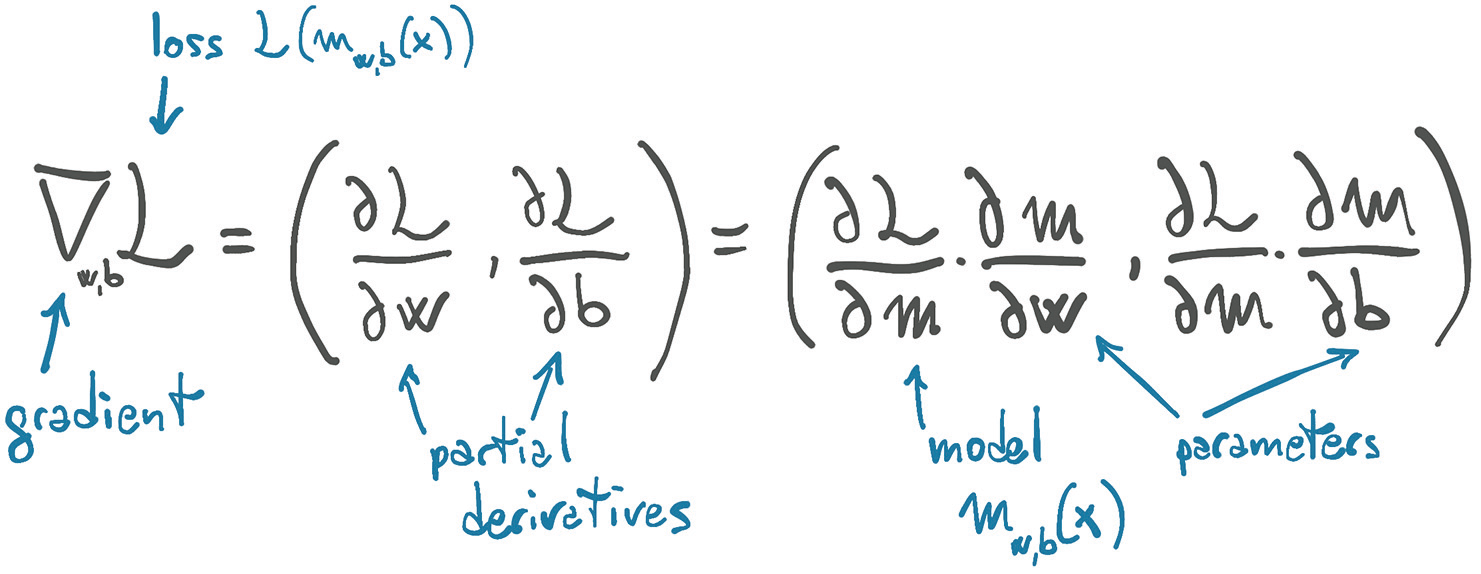


### Iterating to fit the model
We now have everything in place to optimize our parameters. Starting from n initiale
value for a parameter, we can iteratively apply updates to it for a fixed number of iterations,
or until w and b stop changing. There are several stopping criteria; for now,
we’ll stick to a fixed number of iteratio### ns.
THE TRAINING LOOP
Since we’re at it, let’s introduce another piece of terminology. We call a training iteration
during which we update the parameters for all of our training samp`les a`n epoch.

In [ ]:
def training_loop(n_epochs, learning_rate, params, t_f, t_c,
                  print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_f, w, b)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_f, t_c, t_p, w, b)  # <2>

        params = params - learning_rate * grad

        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:  # <3>
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)
        if epoch in {4, 12, 101}:
            print('...')

        if not torch.isfinite(loss).all():
            break  # <3>
            
    return params

Now, let’s invoke our training loop

In [ ]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    t_f = t_f, 
    t_c = t_c)

### OVERTRAINING Our training process literally blew up, leading to losses becoming
iinitenf. This is a clear sign that params is receiving updates that are too large, and
their values start oscillating back and forth as each update overshoots and the next
overcorrects even more. The optimization process is unstable: it diverges instead of
converging to a minimum. We want to see smaller and smaller updates to params, not
larger,

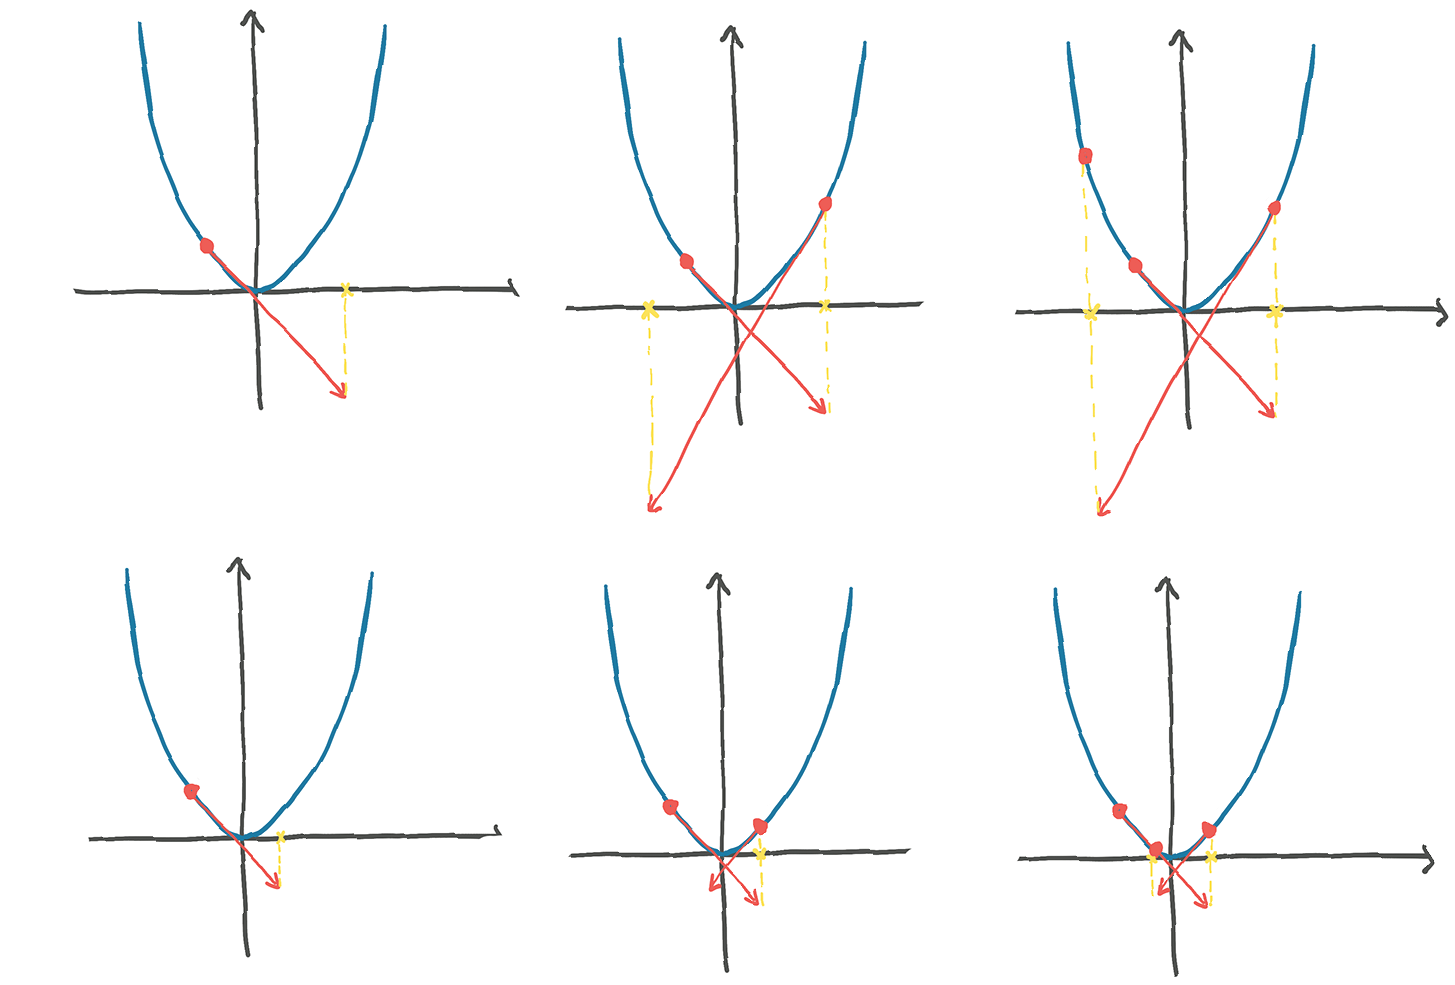

Top: Diverging optimization on a convex function (parabola-like) due to large steps.
Bottom: Converging optimization with small steps.

How can we limit the magnitude of learning_rate * grad? Well, that looks easy. We
could simply choose a smaller learning_rate, and indeed, the learning rate is one of
the things we typically change when training does not go as well as we would like.8 We
usually change learning rates by orders of magnitude, so we might try with 1e-3 or
1e-4, which would decrease the magnitude of the updates by orders of magnitude.
Let’s go with 1e-4 and see how it works out:

In [ ]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-4, 
    params = torch.tensor([1.0, 0.0]), 
    t_f = t_f, 
    t_c = t_c)

Nice—the behavior is now stable. But there’s another problem: the updates to parameters
are very small, so the loss decreases very slowly and eventually stalls. We could
obviate this issue by making learning_rate adaptive: that is, change according to the
magnitude of updates. There are optimization schemes that do t.at,

### Normalizing inputs
We can see that the first-epoch gradient for the weight is about 50 times larger than
the gradient for the bias. This means the weight and bias live in differently scaled
spaces. If this is the case, a learning rate that’s large enough to meaningfully update
one will be so large as to be unstable for the other; and a rate that’s appropriate for
the other won’t be large enough to meaningfully change the first. That means we’re
not going to be able to update our parameters unless we change something about our
formulation of the problem.

In [ ]:
# t_fn is normalized t_f
t_fn = 0.1 * t_f

In [ ]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    t_f = t_fn, # <1>
    t_c = t_c)

Even though we set our learning rate back to 1e-2, parameters don’t blow up during
iterative updates. Let’s take a look at the gradients: they’re of similar magnitude, so
using a single learning_rate for both parameters works just fine. We could probably
do a better job of normalization than a simple rescaling by a factor of 10, but since
doing so is good enough for our needs, we’re going to stick with that for now.

Let’s run the loop for enough iterations to see the changes in params get small. We’ll
change n_epochs to 5,000:

In [ ]:
params = training_loop(
    n_epochs = 5000, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    t_f = t_fn, 
    t_c = t_c,
    print_params = False)

params

Good: our loss decreases while we change parameters along the direction of gradient
descent. It doesn’t go exactly to zero; this could mean there aren’t enough iterations to
converge to zero, or that the data points don’t sit exactly on a lin

The values for `w` and `b` look an awful lot like the numbers we need to use
to convert Celsius to Fahrenheit (after accounting for our earlier normalization when
we multiplied our inputs by 0.1). The exact values would be w=5.5556 and b=-
17.7778. Our fancy thermometer was showing temperatures in Fahrenheit the whole
time. No big discovery, except that our gradient descent optimization process works!
e.

### Visualizing (again)
Let’s revisit plotting our data. Seriously, this is the
first thing anyone doing data science should do. Always plof the data:

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
# Remember that we’re training on the normalized Fahreinheit units. We also use argument unpacking.
t_p = model(t_fn, *params)  # <1>

fig = plt.figure(dpi=600)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
# But we’re plotting the raw Fahreinheit values.
plt.plot(t_f.numpy(), t_p.detach().numpy()) # <2>
plt.plot(t_f.numpy(), t_c.numpy(), 'o')
plt.savefig("temp_unknown_plot.png", format="png")  # bookskip